In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import os
import pandas as pd
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [2]:
# Képméret konstansként

image_size = 28

In [3]:
image_data = []
labels = []

train1_dir = './train1'

for label_folder in tqdm.tqdm(os.listdir(train1_dir)):
    label_path = os.path.join(train1_dir, label_folder)

    if not os.path.isdir(label_path):
        continue

    label = label_folder

    for image_file in os.listdir(label_path):
        image_path = os.path.join(label_path, image_file)

        image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
        
        image = cv.resize(image, (image_size,image_size))


        image_data.append(image)
        labels.append(label)

image_data = np.array(image_data)
labels = np.array(labels)

image_data = image_data / 255.0

100%|██████████| 32/32 [00:04<00:00,  7.83it/s]


In [4]:
image_data_train2 = []
labels_train2 = []

train2_dir = './train2'

for label_folder in tqdm.tqdm(os.listdir(train2_dir)):
    label_path = os.path.join(train2_dir, label_folder)

    if not os.path.isdir(label_path):
        continue

    label = label_folder

    for image_file in os.listdir(label_path):
        image_path = os.path.join(label_path, image_file)

        image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
        
        image = cv.resize(image, (image_size, image_size))


        image_data_train2.append(image)
        labels_train2.append(label)

image_data_train2 = np.array(image_data_train2)
labels_train2 = np.array(labels_train2)

image_data_train2 = image_data_train2 / 255.0

100%|██████████| 32/32 [00:03<00:00,  8.55it/s]


In [5]:
# Train1 és Train2 konkatenálása.

image_data  = np.concatenate((image_data, image_data_train2), axis=0)
labels = np.concatenate((labels, labels_train2), axis=0)

In [6]:
# Prediktálandó osztályok száma konstansként.

num_classes = np.count_nonzero(np.unique(labels))


In [7]:
# Címkék átalakítása megfelelő integerré. Majd One-hot encoding a to_categorical függvénnyel.

labels_int = np.array([int(label[6:]) for label in labels])
label_encoder = LabelEncoder()
labels_int_encoded = label_encoder.fit_transform(labels_int)
labels_int_categorical = to_categorical(labels_int_encoded, num_classes=num_classes)


In [8]:
# Define a function to display images in a grid
def display_images_in_grid(image_data, labels, num_images=10, images_per_row=5):
    # Calculate the number of rows needed based on the number of images and images per row
    num_rows = (num_images // images_per_row) + int(num_images % images_per_row != 0)
    
    # Set up a figure with a grid of subplots
    plt.figure(figsize=(10, num_rows * 2))  # Adjust height based on the number of rows
    
    for i in range(num_images):
        # Create subplots with a grid: num_rows x images_per_row
        plt.subplot(num_rows, images_per_row, i + 1)
        
        # Display the image, using a grayscale colormap
        plt.imshow(image_data[i], cmap='gray')
        
        # Show the corresponding label as the title
        plt.title(labels[i])
        plt.axis('off')  # Turn off axes for better visibility
    
    # Show the images
    plt.tight_layout()  # Adjusts layout to prevent overlap
    plt.show()

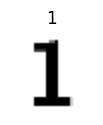

In [9]:
display_images_in_grid(image_data, labels_int_encoded, num_images=1, images_per_row=10)

# Train data felosztása train-test állományra egyenletesen minden címkére

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

In [11]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split the data into training and test sets, ensuring proportional stratification for each class
for train_index, test_index in splitter.split(image_data, labels):
    X_train, X_test = image_data[train_index], image_data[test_index]
    y_train, y_test = labels_int_categorical[train_index], labels_int_categorical[test_index]

# Data Augmentation

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
datagen = ImageDataGenerator(
    rotation_range=10,        # 10 fokig elforgathatjuk a képet
    width_shift_range=0.1,    # Képet vízszintesen 10%-kal eltolni
    height_shift_range=0.1,   # Képet függőlegesen 10%-kal eltolni
    shear_range=0.1,          # 10%-os nyírás
    zoom_range=0.3,           # 30%-os nagyítás
    horizontal_flip=False,     # Vízszintes tükrözés nem ajánlott, mert a karakterek irányítottságot hordoznak
    fill_mode='nearest'       # Képek kiegészítése, ha a transzformáció során üres helyek keletkeznek
)

In [14]:
# Reshape X_train to add a channel dimension to fit for datagen.
X_train = X_train.reshape((X_train.shape[0], image_size, image_size, 1))
datagen.fit(X_train)

# Modell kialakítása

In [15]:
from keras.layers import Activation,Conv2D,MaxPooling2D,Flatten,Dropout,Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping

In [16]:
model = Sequential()

model.add(Conv2D(32,(3,3),padding='valid', input_shape=(image_size, image_size, 1)))
model.add(Activation('relu'))
model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(Conv2D(64,(3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 62)             │        31,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 62)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 621,598 (2.37 MB)

 Trainable params: 621,598 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [19]:
model.fit(X_train,y_train,batch_size=32,epochs=20,verbose=1,validation_data=(X_test,y_test),callbacks=[early_stopping])

Epoch 1/20
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.4966 - loss: 1.9314 - val_accuracy: 0.8336 - val_loss: 0.4483
Epoch 2/20
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.8124 - loss: 0.5331 - val_accuracy: 0.8715 - val_loss: 0.3455
Epoch 3/20
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - accuracy: 0.8385 - loss: 0.4313 - val_accuracy: 0.8770 - val_loss: 0.3134
Epoch 4/20
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.8506 - loss: 0.3824 - val_accuracy: 0.8739 - val_loss: 0.3083
Epoch 5/20
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.8622 - loss: 0.3522 - val_accuracy: 0.8886 - val_loss: 0.2769
Epoch 6/20
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.8681 - loss: 0.3331 - val_accuracy: 0.8923 - val_loss: 0.2713
Epoch 7/20
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.8746 - loss: 0.3086 - val_accuracy: 0.8972 - val_loss: 0.2540
Epoch 8/20
1330/1330 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.8771 -

# Modell visszamérése

In [20]:
from sklearn.metrics import confusion_matrix

In [21]:
pred = model.predict(X_test)
pred_labels = np.argmax(pred, axis=1)
true_labels = np.argmax(y_test, axis=1)

333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


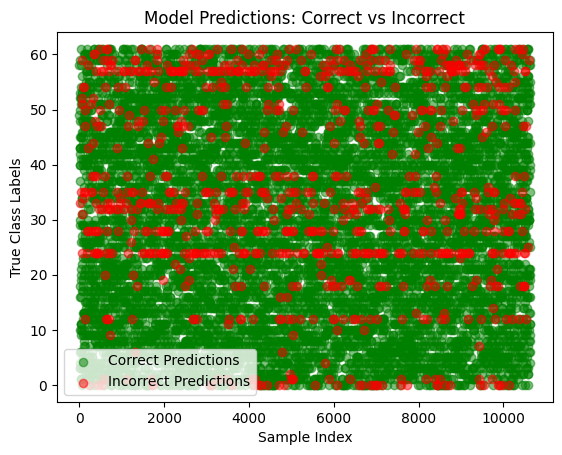

In [22]:
# Find correct and incorrect predictions
correct_indices = np.where(pred_labels == true_labels)[0]
incorrect_indices = np.where(pred_labels != true_labels)[0]

# Create a scatter plot for correct predictions
plt.scatter(correct_indices, true_labels[correct_indices], color='green', label='Correct Predictions', alpha=0.5)

# Create a scatter plot for incorrect predictions
plt.scatter(incorrect_indices, true_labels[incorrect_indices], color='red', label='Incorrect Predictions', alpha=0.5)

# Adding labels and title
plt.xlabel('Sample Index')
plt.ylabel('True Class Labels')
plt.title('Model Predictions: Correct vs Incorrect')
plt.legend()

# Show the plot
plt.show()

# Kideríteni, melyik osztályokban hibázik a modell nagyot, és ott mit tippel.

In [33]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Calculate accuracy for each class
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
class_names = [f'Class {i}' for i in range(len(class_accuracy))]
class_accuracy_dict = dict(zip(class_names, class_accuracy))

# Filter classes with accuracy below x%
low_accuracy_classes = {class_name: accuracy for class_name, accuracy in class_accuracy_dict.items() if accuracy < 0.8}

# Printing the classes with low accuracy
cnt = 0
for class_name, accuracy in low_accuracy_classes.items():
    cnt += 1
    print(f"{class_name}: {accuracy:.2f}")

print("Összesen: " + str(cnt) + " db")

Class 12: 0.79
Class 24: 0.36
Class 28: 0.63
Class 32: 0.74
Class 33: 0.79
Class 35: 0.73
Class 57: 0.54
Összesen: 7 db


In [34]:
# Create a list to store the details of low accuracy predictions
low_accuracy_predictions = []

# Iterate through low accuracy classes and find predictions
for class_name in low_accuracy_classes.keys():
    class_index = int(class_name.split(' ')[-1])  # Extract the class index from the name
    class_indices = np.where(true_labels == class_index)[0]  # Find the indices of true labels that match this class
    
    # Check predictions for these indices
    for idx in class_indices:
        if pred_labels[idx] != true_labels[idx]:  # Only add incorrect predictions
            low_accuracy_predictions.append({
                'Index': idx,
                'True Label': true_labels[idx] + 1, # Azért kell +1, hogy a megfelelő SampleXXX-t lehessen megkapni.
                'Predicted Label': pred_labels[idx] + 1
            })

low_accuracy_df = pd.DataFrame(low_accuracy_predictions)

low_accuracy_df

,Index,True Label,Predicted Label
0,131,13,39
1,637,13,39
2,651,13,39
3,707,13,39
4,1245,13,39
...,...,...,...
402,9098,58,32
403,9648,58,32
404,10238,58,32
405,10512,58,32


# Esetleges modell 128x128-as képfelbontásra.

In [36]:
from tensorflow.keras.layers import BatchNormalization

model128 = Sequential()

# Első konvolúciós blokk
model128.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model128.add(BatchNormalization())  # Batch normalization
model128.add(MaxPooling2D(pool_size=(2, 2)))

# Második konvolúciós blokk
model128.add(Conv2D(64, (3, 3), activation='relu'))
model128.add(BatchNormalization())  # Batch normalization
model128.add(MaxPooling2D(pool_size=(2, 2)))

# Harmadik konvolúciós blokk
model128.add(Conv2D(128, (3, 3), activation='relu'))
model128.add(BatchNormalization())  # Batch normalization
model128.add(MaxPooling2D(pool_size=(2, 2)))

# Negyedik konvolúciós blokk
model128.add(Conv2D(256, (3, 3), activation='relu'))
model128.add(BatchNormalization())  # Batch normalization
model128.add(MaxPooling2D(pool_size=(2, 2)))

# Kép lelapítása
model128.add(Flatten())

# Teljesen összekapcsolt réteg
model128.add(Dense(512, activation='relu'))
model128.add(Dropout(0.5))  # Dropout réteg a túlilleszkedés csökkentésére

# Kimeneti réteg
model128.add(Dense(num_classes, activation='softmax'))

# Modell összefoglaló
model128.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 62)             │        31,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,140,670 (19.61 MB)

 Trainable params: 5,139,710 (19.61 MB)

 Non-trainable params: 960 (3.75 KB)